In [1]:
! pip install pyspark -q

In [2]:
from google.colab import drive

# Mount the Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Read data into a Spark dataframe

In [ ]:
#!ls /content/drive/MyDrive

In [3]:
spark = SparkSession\
        .builder\
        .appName("IMDb Details")\
        .getOrCreate()

In [4]:
# Read Parquet file into a Spark DataFrame
df_parquet = spark.read.parquet('/content/drive/MyDrive/movie-recommendation-system/User-Movie-data.parquet')

In [5]:
df_parquet.show(5)

+------+---------------+------+-------+------+------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+---------------+
|imdbId|          Title|UserID|MovieID|Genres|Rating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|       director|
+------+---------------+------+-------+------+------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+---------------+
|109068|Airheads (1994)|    26|    413|Comedy|     2| 978139790|2000-12-30 01:29:50|     M| 25|         7|   23112|  2.81936|Michael Lehmann|    413|Steve Buscemi, Ch...|       Airheads|      92|        6.2|Three would be ro...|Michael Lehmann|
|109068|Airheads (19

## This dataset includes movie-related information such as movie and user IDs, ratings, genres, and movie details (e.g., title, director, plot). It also contains user demographics (e.g., gender, age, occupation), timestamps, and additional movie attributes like runtime, IMDb rating, and cast. Some fields allow missing values.

In [6]:
df_parquet.printSchema()
df_parquet.count()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- avgRating: double (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: string (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- director: string (nullable = true)



916355

In [7]:
from pyspark.sql import functions as F

# Step 1: Rename 'Rating' to 'UserRating' and convert 'UserRating' and 'avgRating' to integer type
df_parquet_cleaned = df_parquet \
    .withColumnRenamed('Rating', 'UserRating') \
    .withColumn('UserRating', F.col('UserRating').cast('int')) \
    .withColumn('avgRating', F.col('avgRating').cast('int'))

# Step 2: Drop the 'director' column
df_parquet_cleaned = df_parquet_cleaned.drop('director')

# Show the resulting DataFrame
df_parquet_cleaned.show(5)

+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+
|imdbId|          Title|UserID|MovieID|Genres|UserRating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|
+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+
|109068|Airheads (1994)|    26|    413|Comedy|         2| 978139790|2000-12-30 01:29:50|     M| 25|         7|   23112|        2|Michael Lehmann|    413|Steve Buscemi, Ch...|       Airheads|      92|        6.2|Three would be ro...|
|109068|Airheads (1994)|    48|    413|Comedy|         3| 978147204|

### This code defines a User Defined Function (UDF) to map occupation codes to their corresponding occupation names using a dictionary. It then applies this UDF to a DataFrame (`df_parquet_cleaned`) to add a new column, `Occupation_Name`, and displays the first 5 rows of the updated DataFrame.
   Occupation Codes
   
    *  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [8]:
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import StringType

# Occupation mapping dictionary
occupation_dict = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

# Create a UDF (User Defined Function) to map the occupation code to the occupation name
occupation_udf = udf(lambda x: occupation_dict.get(x, "Unknown"), StringType())

# Add the occupation name to the Parquet DataFrame
df_parquet_cleaned = df_parquet_cleaned.withColumn("Occupation_Name", occupation_udf(col("Occupation")))

# Show the updated DataFrame with the new column
df_parquet_cleaned.show(5)


+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+
|imdbId|          Title|UserID|MovieID|Genres|UserRating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|     Occupation_Name|
+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+
|109068|Airheads (1994)|    26|    413|Comedy|         2| 978139790|2000-12-30 01:29:50|     M| 25|         7|   23112|        2|Michael Lehmann|    413|Steve Buscemi, Ch...|       Airheads|      92|        6.2|Three would be ro...|execut

In [9]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- avgRating: integer (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: string (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



In [ ]:

df_parquet_cleaned = df_parquet_cleaned.drop('avgRating')
df_parquet_cleaned = df_parquet_cleaned.withColumn('rating_imdb', df_parquet_cleaned['rating_imdb'].cast('int'))



In [12]:
# Check for missing values
df_parquet_cleaned.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_parquet_cleaned.columns]).show()

# Drop rows with missing UserID, MovieID, or UserRating
df_parquet_cleaned = df_parquet_cleaned.dropna(subset=["UserID", "MovieID", "UserRating"])


+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+---------+----------+-------+--------+---------------+--------+-----------+------------+---------------+
|imdbId|Title|UserID|MovieID|Genres|UserRating|Timestamp|date_time|Gender|Age|Occupation|Zip_Code|avgRating|directedBy|item_id|starring|localized_title|runtimes|rating_imdb|plot_outline|Occupation_Name|
+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+---------+----------+-------+--------+---------------+--------+-----------+------------+---------------+
|     0|    0|     0|      0|     0|         0|        0|        0|     0|  0|         0|       0|        0|        31|      0|     238|              0|       0|          0|           0|              0|
+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+---------+----------+-------+--------+---------------+--------+-----------+------------+--

In [14]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- avgRating: integer (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: string (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



## Below shows a simple distribution of IMDb rating values.

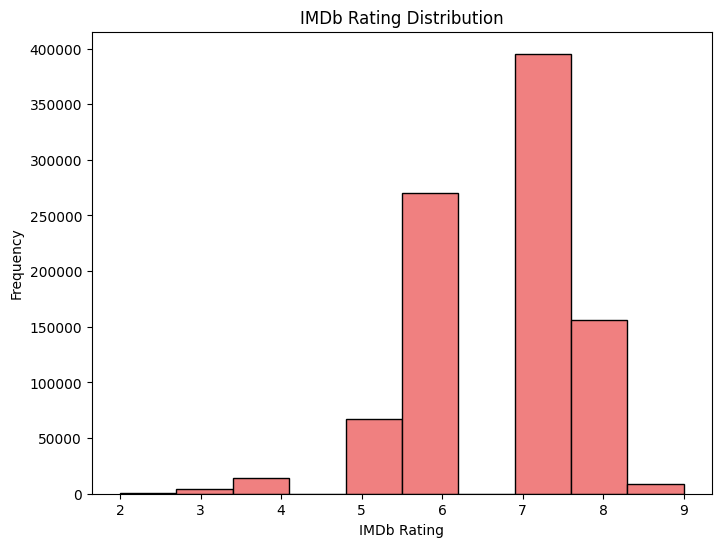

In [ ]:


import matplotlib.pyplot as plt

rating_imdb_data = df_parquet_cleaned.select('rating_imdb').toPandas()


plt.figure(figsize=(8, 6))
plt.hist(rating_imdb_data['rating_imdb'], bins=10, color='lightcoral', edgecolor='black')
plt.title('IMDb Rating Distribution')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


scaler = MinMaxScaler()

# Normalize user ratings (assuming they are already integers)
user_ratings_normalized = scaler.fit_transform(df_parquet_cleaned.select('UserRating').toPandas())

# Normalize IMDb ratings (convert to int if not already done)
imdb_ratings_normalized = scaler.fit_transform(df_parquet_cleaned.select('rating_imdb').toPandas())



### Below is a heatmap of genre preference by zip code region. This shows us the most popular genres across our geographic feature. The top 3 genres across the top 20 most active regions are Drama, Comedy, and Action.

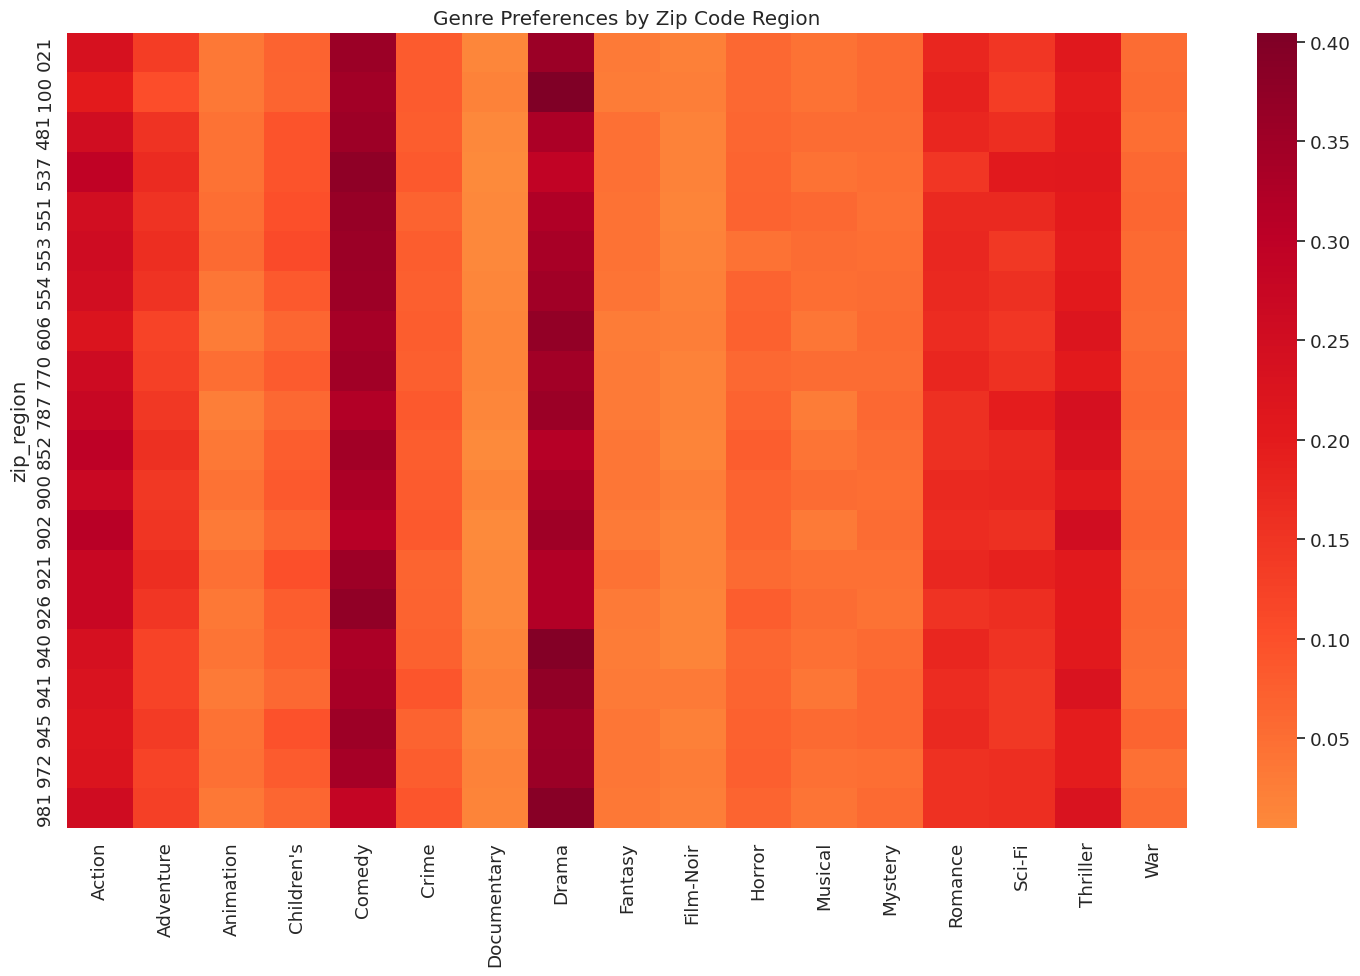

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

total_rows = df_parquet.count()

# calculate middle index for splitting
half_rows = total_rows // 2

# Create a copy of the cleaned dataframe
df = df_parquet_cleaned.limit(half_rows).toPandas()

# Split the Genres column into separate columns
genres_split = df['Genres'].str.get_dummies(sep='|')

# Merge the genres back with the original DataFrame
df = pd.concat([df, genres_split], axis=1)

# Extract first 3 digits of zipcode for regional analysis
df['zip_region'] = df['Zip_Code'].astype(str).str[:3]

# Get the genre columns
genre_cols = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy',
             'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
             'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
             'Thriller', 'War']

# Filter to the top 20 most active regions in the dataset
'''
"Active regions" in this case are defined as regions with many users rating many movies
who were from the region, making the region's count high in our dataset.
'''
top_regions = df['zip_region'].value_counts().head(20).index
region_genre_dist = df[df['zip_region'].isin(top_regions)].groupby('zip_region')[genre_cols].mean()

# Create heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(region_genre_dist, cmap='YlOrRd', center=0)
plt.title('Genre Preferences by Zip Code Region')
plt.tight_layout()
plt.show()

The code below compares user and IMDb ratings. IMDb ratings (orange) are tightly clustered around 0.8, indicating consistency, while user ratings (blue) show more variability, peaking near 0.9. To align the scales, user ratings (originally out of 5) were normalized to match IMDb ratings (out of 10). Both distributions show smaller peaks at lower values (0.2–0.4), reflecting minority ratings. The differences suggest that users tend to rate more generously than IMDb. Despite this, the two distributions are similar, indicating that the user ratings sample is not skewed

<ipython-input-14-05bc2644ab3e>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(
<ipython-input-14-05bc2644ab3e>:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(


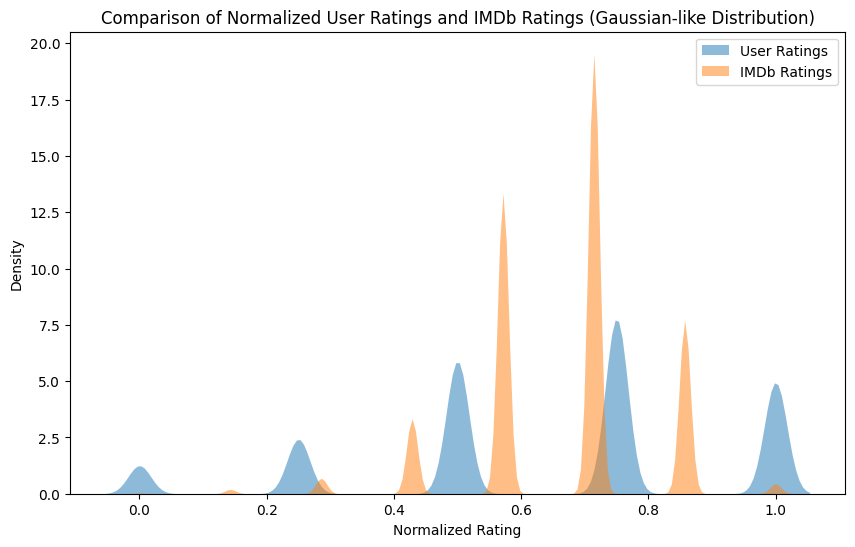

In [ ]:
import pandas as pd
ratings_df = pd.DataFrame({
    'UserRatings': user_ratings_normalized.flatten(),
    'IMDbRatings': imdb_ratings_normalized.flatten()
})
# Plot the Gaussian-like distributions of both normalized ratings using KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=ratings_df, x="UserRatings", fill=True, common_norm=False,
    palette="Blues", alpha=.5, linewidth=0, label='User Ratings'
)

sns.kdeplot(
    data=ratings_df, x="IMDbRatings", fill=True, common_norm=False,
    palette="YlOrBr", alpha=.5, linewidth=0, label='IMDb Ratings'
)

# Add labels and title
plt.title('Comparison of Normalized User Ratings and IMDb Ratings (Gaussian-like Distribution)')
plt.xlabel('Normalized Rating')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()


In [ ]:
from pyspark.sql import functions as F

# Step 1: Group by Occupation and calculate average user rating for each occupation
occupation_avg_rating = df_parquet_cleaned.groupBy("Occupation_Name") \
    .agg(
        F.avg("UserRating").alias("Avg_UserRating"),  # Calculate average user rating
        F.count("UserID").alias("User_Count")  # Count the number of users in each occupation
    )

# Step 2: Sort by User_Count in descending order and take the top 10 occupations
top_10_occupations = occupation_avg_rating.orderBy(F.col("User_Count").desc()).limit(10)

# Show the top 10 occupations with their average user rating and user count
top_10_occupations.show()


+--------------------+------------------+----------+
|     Occupation_Name|    Avg_UserRating|User_Count|
+--------------------+------------------+----------+
|college/grad student| 3.526505472553997|    120145|
|other or not spec...|3.5293792826485277|    119523|
|executive/managerial|3.5902248652666793|     96858|
|   academic/educator| 3.566375183506734|     78335|
| technician/engineer| 3.606288684574244|     66564|
|              writer|3.4826946510739685|     54983|
|          programmer|3.6414716748768474|     51968|
|              artist| 3.556769804696072|     45570|
|     sales/marketing|3.6084449158159884|     45258|
|       self-employed| 3.588229714990278|     42174|
+--------------------+------------------+----------+



The plot highlights the top 10 occupations by user count, with "college/grad student" having the highest count (120,145) and "self-employed" the lowest (42,174). Occupations with higher user counts, such as "executive/managerial" and "academic/educator," suggest more stable ratings, while those with lower counts may introduce more variability.

<ipython-input-16-3a4012b194c2>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-16-3a4012b194c2>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


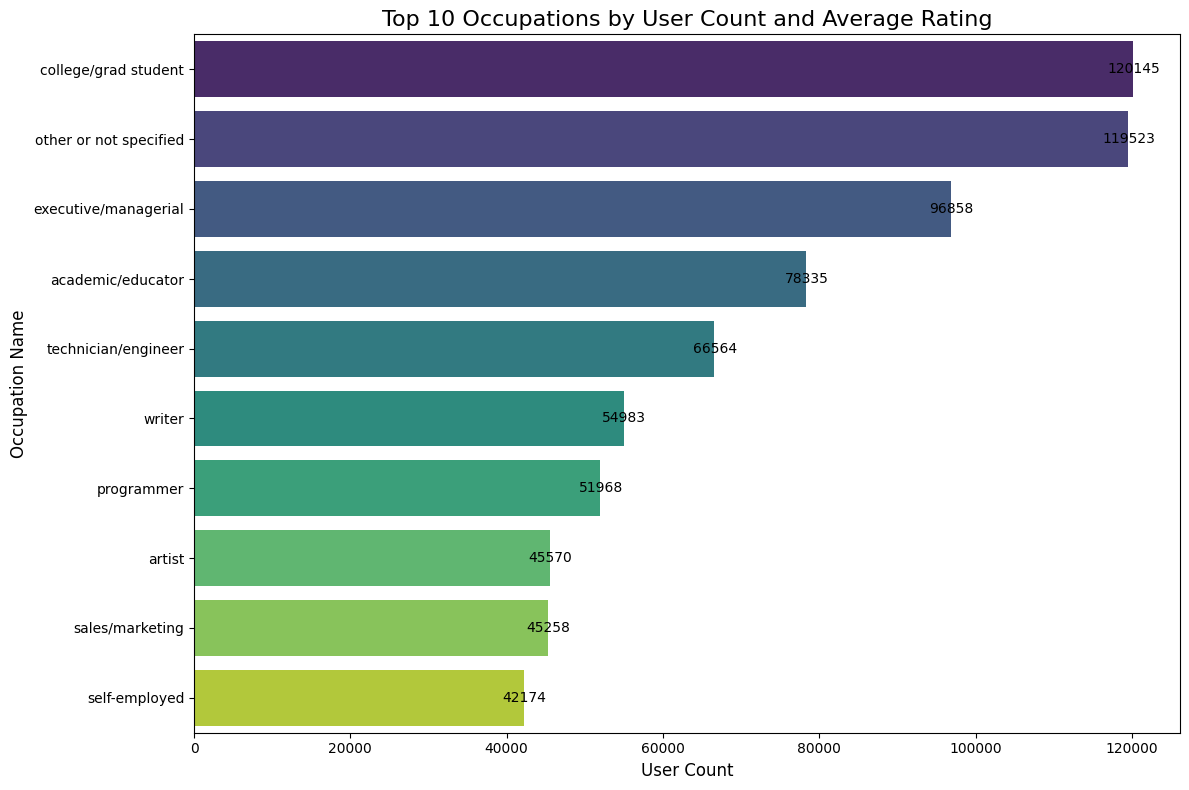

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Convert the Spark DataFrame to a Pandas DataFrame for visualization
top_10_occupations_pd = top_10_occupations.toPandas()

# Step 2: Create a figure for visualization
plt.figure(figsize=(12, 8))

# Create a barplot for the top 10 occupations by user count
sns.barplot(
    x="User_Count", y="Occupation_Name", data=top_10_occupations_pd,
    palette="viridis", orient="h", ci=None
)

# Add labels and title
plt.title('Top 10 Occupations by User Count and Average Rating', fontsize=16)
plt.xlabel('User Count', fontsize=12)
plt.ylabel('Occupation Name', fontsize=12)

# Annotate user counts on the bars
for index, value in enumerate(top_10_occupations_pd['User_Count']):
    plt.text(value + 50, index, str(value), color='black', ha="center", va="center")

# Show the plot
plt.tight_layout()
plt.show()


The heatmap matrix below presents the average user ratings for different genre combinations across several occupations. Each occupation is associated with specific genres, and the values represent the average rating users have given to movies in these genres.

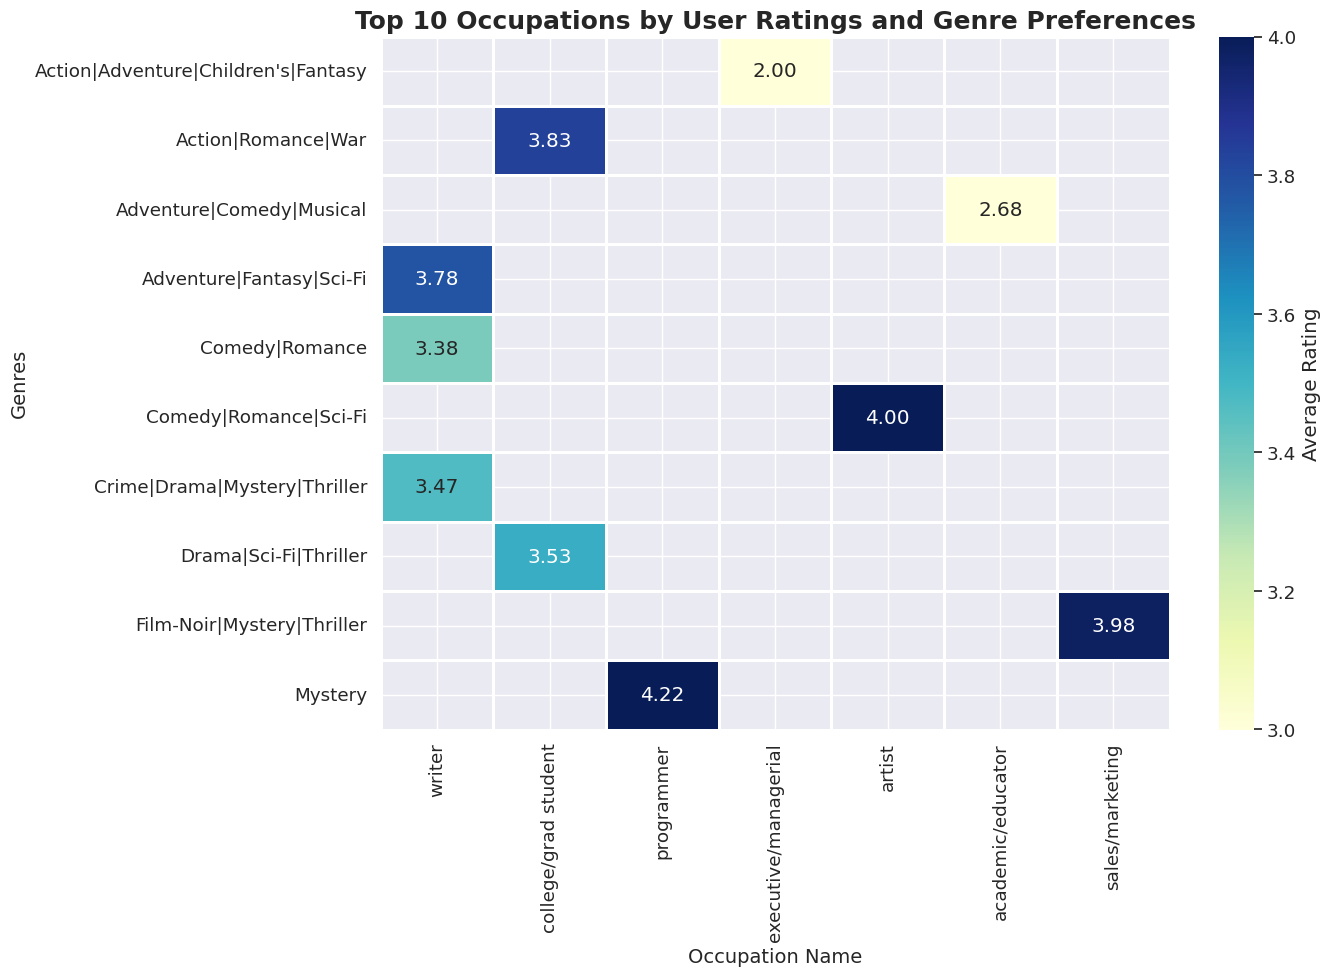

Occupation_Name                        writer  college/grad student  \
Action|Adventure|Children's|Fantasy       NaN                   NaN   
Action|Romance|War                        NaN              3.834483   
Adventure|Comedy|Musical                  NaN                   NaN   
Adventure|Fantasy|Sci-Fi             3.780822                   NaN   
Comedy|Romance                       3.384952                   NaN   
Comedy|Romance|Sci-Fi                     NaN                   NaN   
Crime|Drama|Mystery|Thriller         3.468750                   NaN   
Drama|Sci-Fi|Thriller                     NaN              3.528926   
Film-Noir|Mystery|Thriller                NaN                   NaN   
Mystery                                   NaN                   NaN   

Occupation_Name                      programmer  executive/managerial  artist  \
Action|Adventure|Children's|Fantasy         NaN                   2.0     NaN   
Action|Romance|War                          NaN         

In [ ]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate the average rating for each occupation and genre combination
avg_ratings_by_occupation_genre = df_parquet_cleaned \
    .groupBy("Occupation_Name", "Genres") \
    .agg(F.avg("UserRating").alias("Avg_UserRating"))

# Step 2: Filter for top 10 occupations by user count
top_10_occupations = df_parquet_cleaned.groupBy("Occupation_Name") \
    .count().orderBy("count", ascending=False).limit(10)

# Join the top 10 occupations with the genre ratings
top_10_occupation_genre_ratings = avg_ratings_by_occupation_genre \
    .join(top_10_occupations, on="Occupation_Name") \
    .select("Occupation_Name", "Genres", "Avg_UserRating").limit(10)

# Step 3: Pivot the data to create a matrix (Occupation x Genre)
pivoted_df = top_10_occupation_genre_ratings \
    .groupBy("Occupation_Name") \
    .pivot("Genres") \
    .agg(F.first("Avg_UserRating"))

# Step 4: Convert to Pandas DataFrame for visualization
pivoted_pd = pivoted_df.toPandas()

# Step 5: Plot the heatmap
plt.figure(figsize=(14, 10))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(pivoted_pd.set_index("Occupation_Name").transpose(),
            annot=True,
            fmt='.2f',  # Display two decimal places for readability
            cmap="YlGnBu",  # Color map with pleasant gradient
            linewidths=1,   # Add gridlines for better separation
            linecolor='white',  # White gridlines for clarity
            cbar_kws={'label': 'Average Rating'},  # Color bar label
            vmin=3, vmax=4)  # Restrict color bar to range between 3 and 4

# Add labels and title
plt.title('Top 10 Occupations by User Ratings and Genre Preferences', fontsize=18, fontweight='bold')
plt.ylabel('Genres', fontsize=14)
plt.xlabel('Occupation Name', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print the pivoted matrix
print(pivoted_pd.set_index("Occupation_Name").transpose())


The code below presents the average user ratings across various gender and genre combinations. For female users, ratings are available for genres such as Action, Comedy, Film Noir, indicating a broad spread of preferences across different types of content. This plot shows the top 10 genre preferences and average user ratings for each gender.

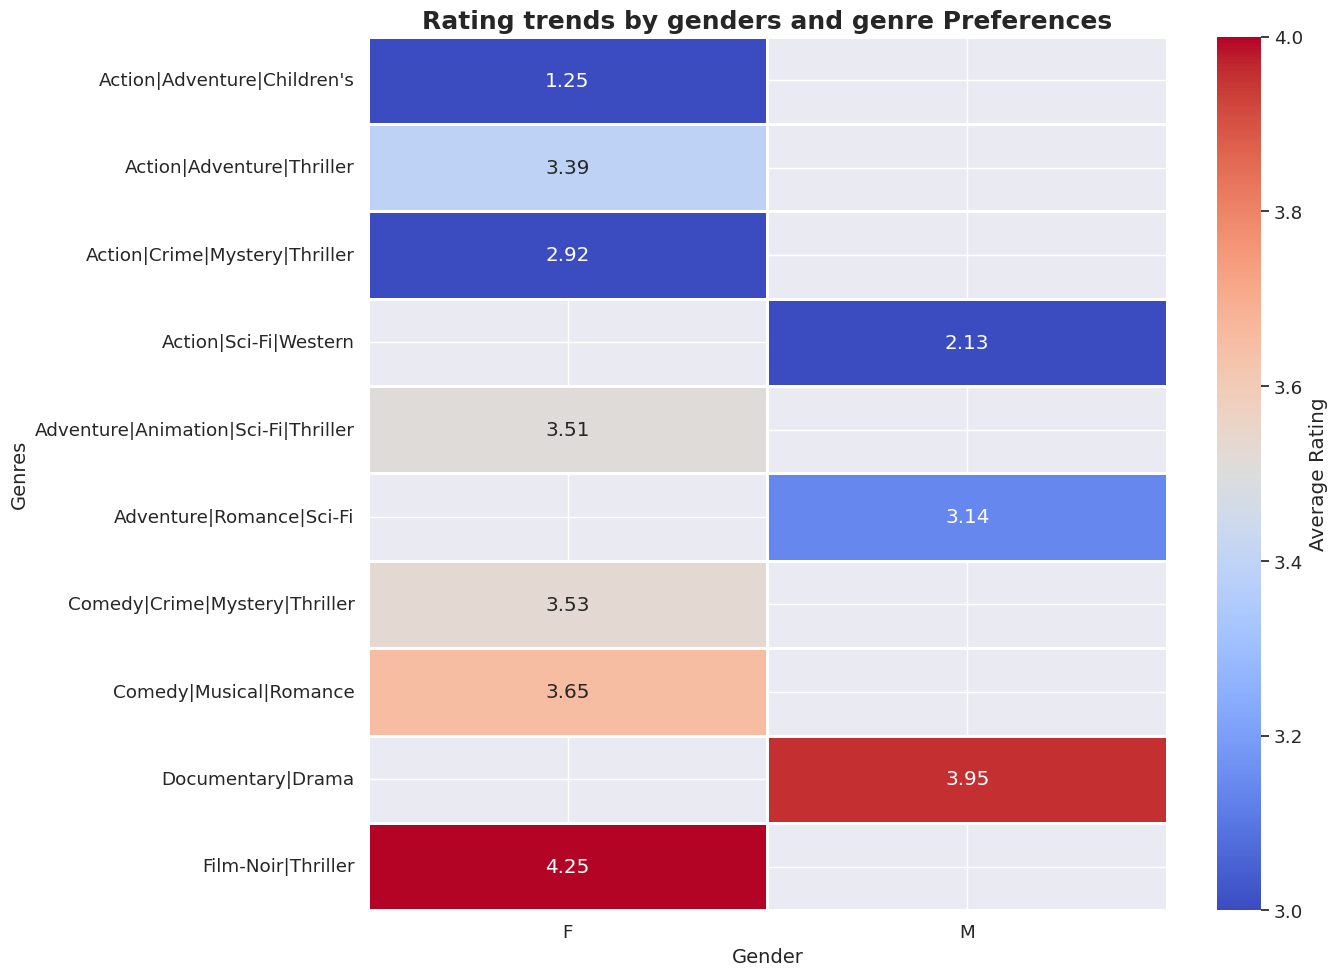

In [15]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate the average rating for each gender and genre combination
avg_ratings_by_gender_genre = df_parquet_cleaned \
    .groupBy("Gender", "Genres") \
    .agg(F.avg("UserRating").alias("Avg_UserRating"))

# Step 2: Filter for top 10 genders by user count
top_10_genders = df_parquet_cleaned.groupBy("Gender") \
    .count().orderBy("count", ascending=False).limit(10)

# Join the top 10 genders with the genre ratings
top_10_gender_genre_ratings = avg_ratings_by_gender_genre \
    .join(top_10_genders, on="Gender") \
    .select("Gender", "Genres", "Avg_UserRating").limit(10)

# Step 3: Pivot the data to create a matrix (Gender x Genre)
pivoted_df = top_10_gender_genre_ratings \
    .groupBy("Gender") \
    .pivot("Genres") \
    .agg(F.first("Avg_UserRating"))

# Step 4: Convert to Pandas DataFrame for visualization
pivoted_pd = pivoted_df.toPandas()

# Step 5: Plot the heatmap with a new color scheme
plt.figure(figsize=(14, 10))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(pivoted_pd.set_index("Gender").transpose(),
            annot=True,
            fmt='.2f',  # Display two decimal places for readability
            cmap="coolwarm",  # New color map
            linewidths=1,   # Add gridlines for better separation
            linecolor='white',  # White gridlines for clarity
            cbar_kws={'label': 'Average Rating'},  # Color bar label
            vmin=3, vmax=4)  # Restrict color bar to range between 3 and 4

# Add labels and title
plt.title('Rating trends by genders and genre Preferences', fontsize=18, fontweight='bold')
plt.ylabel('Genres', fontsize=14)
plt.xlabel('Gender', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


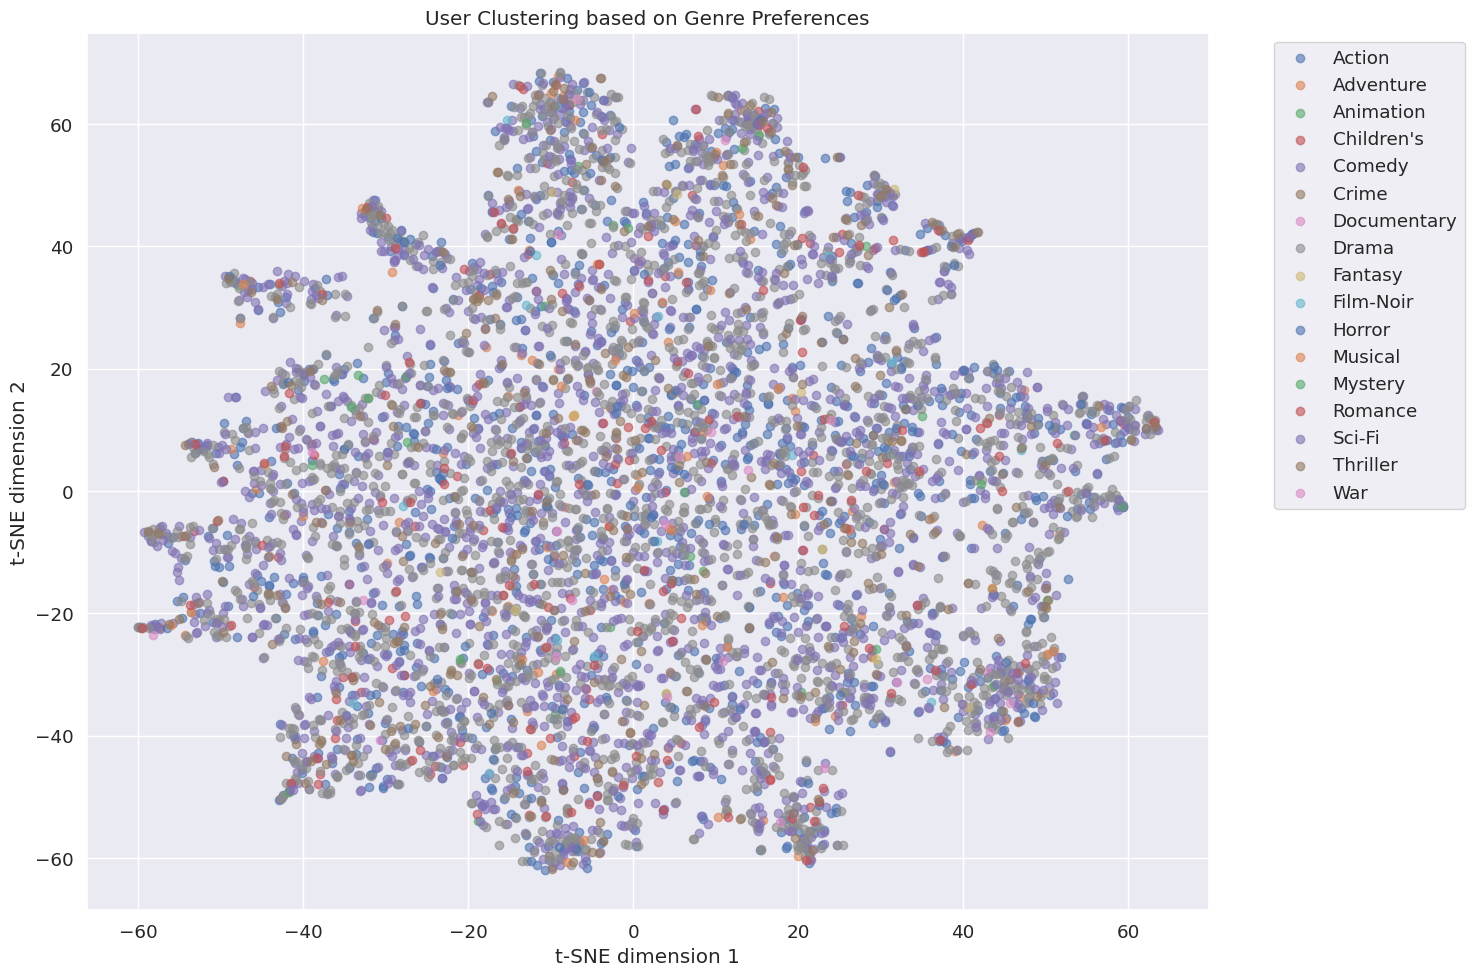

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Create user-genre matrix
user_genre_matrix = df.groupby('UserID')[genre_cols].mean()

# Standardize the features
scaler = StandardScaler()
user_genre_scaled = scaler.fit_transform(user_genre_matrix)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
user_clusters = tsne.fit_transform(user_genre_scaled)

# Create DataFrame with cluster coordinates
cluster_df = pd.DataFrame(user_clusters, columns=['x', 'y'])
cluster_df['UserID'] = user_genre_matrix.index

# Add dominant genre for each user
user_dominant_genre = user_genre_matrix.idxmax(axis=1)
cluster_df['Dominant_Genre'] = user_dominant_genre

# Visualize clusters
plt.figure(figsize=(15, 10))
for genre in genre_cols:
    mask = cluster_df['Dominant_Genre'] == genre
    if sum(mask) > 0:  # Only plot if there are users with this dominant genre
        plt.scatter(cluster_df[mask]['x'], cluster_df[mask]['y'],
                   label=genre, alpha=0.6)

plt.title('User Clustering based on Genre Preferences')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('user_clusters.png', bbox_inches='tight')
plt.show()

The "User Clustering based on Genre Preferences" visualization presents a t-SNE dimensionality reduction plot that maps users into a two-dimensional space based on their genre preferences, with different colors representing different movie genres. The scattered points form a few discernable clusters and large overlapping regions, showing how users group together based on similar taste patterns. While we were expecting to observe several well-defined clusters, instead there's significant overlap between genres in the central region of the plot, suggesting many users have diverse tastes, with most falling into mixed-preference zones where multiple genres intersect. This complexity in viewer taste patterns has important implications for recommendation systems, suggesting that recommender systems should be flexible enough to suggest movies across different genres rather than pigeonholing users into strict genre-based categories.

In [ ]:
# Print some statistics about the clusters
print("\nNumber of users in each dominant genre cluster:")
print(cluster_df['Dominant_Genre'].value_counts())


Number of users in each dominant genre cluster:
Dominant_Genre
Drama          2038
Comedy         1732
Action         1009
Sci-Fi          372
Thriller        322
Romance         151
Horror          112
Children's       73
Adventure        73
Musical          33
Crime            30
Mystery          21
Animation        18
War              18
Film-Noir        16
Fantasy          14
Documentary       7
Name: count, dtype: int64


The heatmap below displays genre preferences by age. Most genres retain a fairly similar preference score across user age, with there being a preference for children's movies in younger viewers. In general, users prefer Drama, Comedy, Action, and Thriller as the top 4 genres.

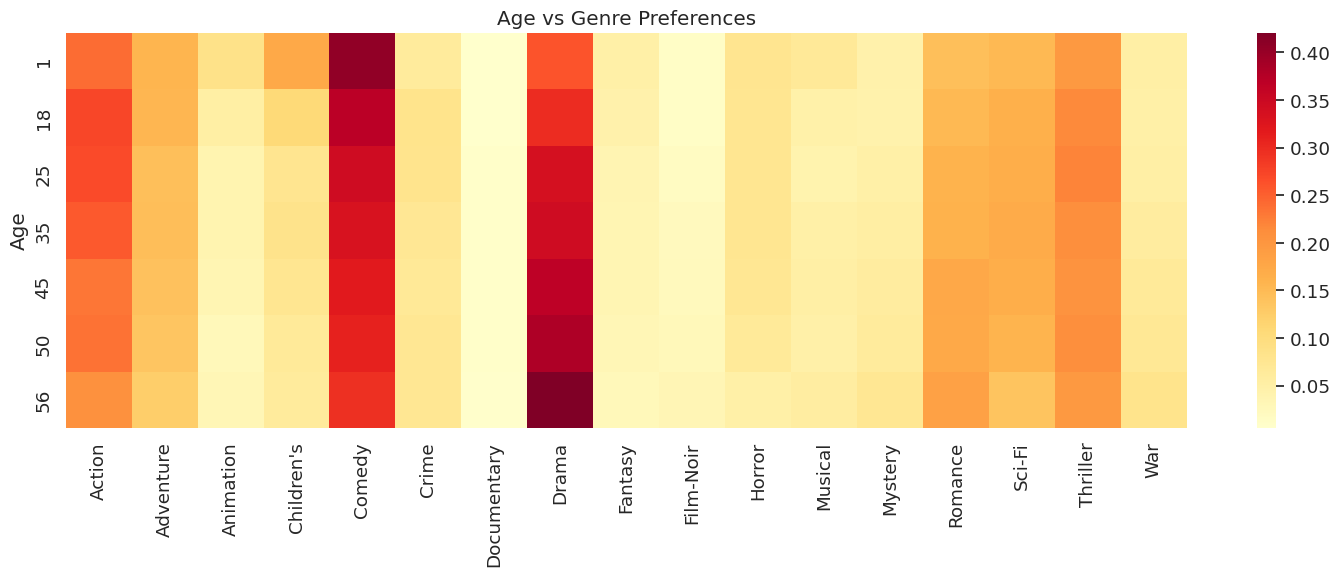

In [18]:
# Age Distribution vs Genre Preference
plt.figure(figsize=(15, 6))
age_genre_corr = df.groupby('Age')[genre_cols].mean()
sns.heatmap(age_genre_corr, cmap='YlOrRd')
plt.title('Age vs Genre Preferences')
plt.tight_layout()
plt.show()

Most of the genres are rated between 3.5 and 4 stars by the users in our dataset.

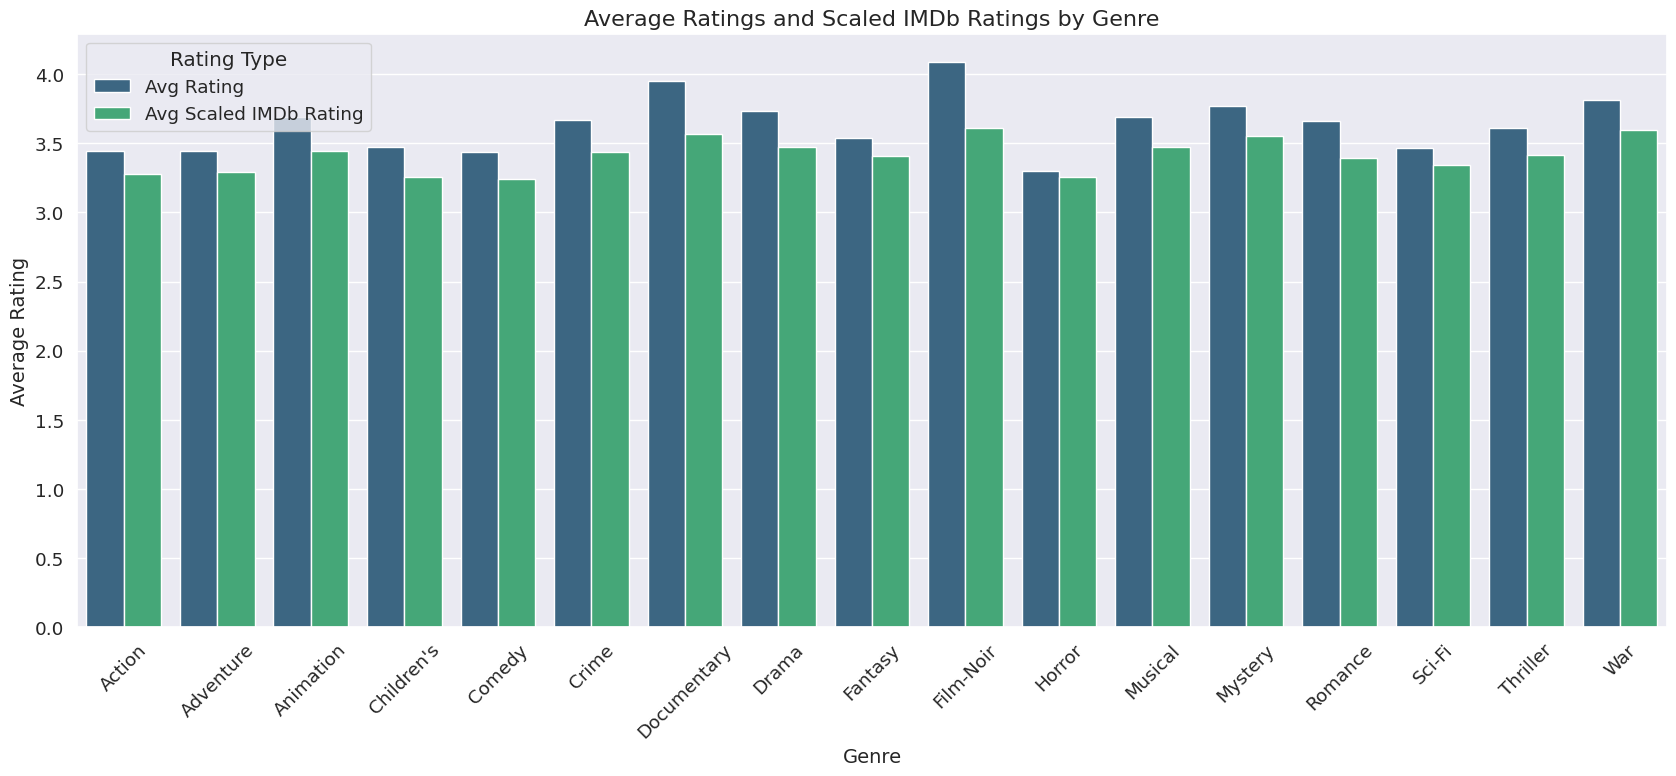

In [ ]:
# avg ratings
genre_ratings = []
for genre in genre_cols:
    avg_rating = df[df[genre] == 1]['UserRating'].mean()
    avg_imdb_scaled_rating = df[df[genre] == 1]['rating_imdb_scaled'].mean()
    genre_ratings.append({'Genre': genre, 'Avg Rating': avg_rating, 'Avg Scaled IMDb Rating': avg_imdb_scaled_rating})

# df
genre_ratings_df = pd.DataFrame(genre_ratings)

# transform data
# Melt the DataFrame to "long format" suitable for grouped bar plotting
melted_ratings = genre_ratings_df.melt(id_vars='Genre',
                                       value_vars=['Avg Rating', 'Avg Scaled IMDb Rating'],
                                       var_name='Rating Type',
                                       value_name='Average')

# bar-in-bar plot
plt.figure(figsize=(17, 8))
sns.barplot(data=melted_ratings, x='Genre', y='Average', hue='Rating Type', palette='viridis')

# graph
plt.xticks(rotation=45)
plt.title('Average Ratings and Scaled IMDb Ratings by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.legend(title='Rating Type')
plt.tight_layout()
plt.show()

This visual compares our two different rating systems across our movie genres. We can see disparities between how the general audience and IMDb users rate different genres. The overall pattern indicates that, while both rating systems generally track together, IMDb ratings tend to be slightly more critical across most genres.

In [ ]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: integer (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



In [21]:
total_rows = df_parquet.count()
# Calculate the middle index for splitting
half_rows = total_rows // 10
# First half of the DataFrame
first_half = df_parquet_cleaned.limit(half_rows)


In [22]:
# Convert the first half to Pandas (if it's small enough)
first_half_pd = first_half.toPandas()



In [23]:
from pyspark.sql.functions import to_timestamp

# Check for missing values in the dataframe
missing_values = first_half_pd.isnull().sum()
print(f"Missing values:\n{missing_values}")




Missing values:
imdbId              0
Title               0
UserID              0
MovieID             0
Genres              0
UserRating          0
Timestamp           0
date_time           0
Gender              0
Age                 0
Occupation          0
Zip_Code            0
avgRating           0
directedBy          0
item_id             0
starring           36
localized_title     0
runtimes            0
rating_imdb         0
plot_outline        0
Occupation_Name     0
dtype: int64


In [19]:
print(df_parquet_cleaned.columns)

['imdbId', 'Title', 'UserID', 'MovieID', 'Genres', 'UserRating', 'Timestamp', 'date_time', 'Gender', 'Age', 'Occupation', 'Zip_Code', 'avgRating', 'directedBy', 'item_id', 'starring', 'localized_title', 'runtimes', 'rating_imdb', 'plot_outline', 'Occupation_Name']


#    +++++++     Modelling Section     +++++++

## Best Model at preliminary stages
This code builds a hybrid movie recommendation system by combining collaborative filtering (using ALS) with content-based filtering. Collaborative predictions are generated based on user-item interactions, while content-based scores are derived from genre-based features and average ratings. The final predictions are a weighted combination of both approaches, enhancing recommendation accuracy.

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Sample Data
df_sample = df_parquet.sample(fraction=0.9, seed=42)

# Step 2: Collaborative Filtering (ALS)
ratings_df = df_sample.select("UserID", "MovieID", "Rating").distinct()
(training, test) = ratings_df.randomSplit([0.8, 0.2], seed=42)

als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="UserID",
    itemCol="MovieID",
    ratingCol="Rating",
    coldStartStrategy="drop"
)
als_model = als.fit(training)
collab_predictions = als_model.transform(test)

# Step 3: Content-Based Filtering
# Tokenize genres
tokenizer = Tokenizer(inputCol="Genres", outputCol="Genres_Tokens")
df_genres = tokenizer.transform(df_sample)

# Compute TF-IDF
hashing_tf = HashingTF(inputCol="Genres_Tokens", outputCol="rawFeatures")
tf = hashing_tf.transform(df_genres)

idf = IDF(inputCol="rawFeatures", outputCol="content_features")
idf_model = idf.fit(tf)
content_features = idf_model.transform(tf)

# Generate a simple content-based score (average rating by MovieID for simplicity)
content_scores = df_sample.groupBy("MovieID").agg({"Rating": "avg"}) \
    .withColumnRenamed("avg(Rating)", "content_based_score")

# Step 4: Combine Results
# Join collaborative predictions with content-based scores
final_predictions = collab_predictions.join(
    content_scores, on="MovieID", how="left"
).withColumn(
    "Hybrid_Prediction",
    col("prediction") * 0.6 + col("content_based_score") * 0.4
)

# Filter out rows with null predictions
final_predictions = final_predictions.filter(col("Hybrid_Prediction").isNotNull())

In [ ]:
# Step 5: Evaluate Hybrid Recommender
# RMSE
evaluator_rmse = RegressionEvaluator(
    metricName="rmse",
    labelCol="Rating",
    predictionCol="Hybrid_Prediction"
)
rmse = evaluator_rmse.evaluate(final_predictions)

# MAE
evaluator_mae = RegressionEvaluator(
    metricName="mae",
    labelCol="Rating",
    predictionCol="Hybrid_Prediction"
)
mae = evaluator_mae.evaluate(final_predictions)

# R²
evaluator_r2 = RegressionEvaluator(
    metricName="r2",
    labelCol="Rating",
    predictionCol="Hybrid_Prediction"
)
r2 = evaluator_r2.evaluate(final_predictions)

# Print Metrics
print(f"RMSE of Hybrid Recommender: {rmse}")
print(f"MAE of Hybrid Recommender: {mae}")
print(f"R² of Hybrid Recommender: {r2}")


RMSE of Hybrid Recommender: 0.8847873043345177
MAE of Hybrid Recommender: 0.710715925303321
R² of Hybrid Recommender: 0.3708870754575039


The hybrid recommender system's performance is evaluated using three key metrics. The RMSE (Root Mean Squared Error) is 0.8847, indicating the average deviation between predicted and actual ratings. The MAE (Mean Absolute Error) is 0.7107, representing the average magnitude of errors in predictions. The R² value is 0.371, showing that the model explains about 37% of the variance in the data, suggesting potential for further improvements in predictive accuracy.

## Best Model at Intermediate Stage

This code performs collaborative filtering, content-based filtering, and combines them to form a hybrid recommender system. It first trains an ALS (Alternating Least Squares) model for collaborative filtering, then calculates user genre preferences and content-based scores. The model incorporates IMDb ratings to improve recommendations, assigning a final score based on a weighted combination of these factors.

After making recommendations, the code evaluates the model using RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error). It also computes the **Hit Rate** at top-k (10 in this case) by comparing recommended movies with actual ones and calculates **Catalog Coverage**, measuring the proportion of unique movies recommended. Finally, the metrics are displayed, providing insights into the system's performance.

In [ ]:
from pyspark.sql.functions import col, lit, coalesce, desc, explode, collect_list, array_intersect
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lit, coalesce, desc, explode
import pyspark.sql.functions as F


# Step 1: Collaborative Filtering (ALS Model)
ratings_df = df_parquet.select("UserID", "MovieID", "Rating").distinct()
(training, test) = ratings_df.randomSplit([0.8, 0.2], seed=42)

als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="UserID",
    itemCol="MovieID",
    ratingCol="Rating",
    coldStartStrategy="drop"
)
als_model = als.fit(training)
collab_predictions = als_model.transform(test)

# Step 2: User Genre Preferences
user_genre_preferences = (
    df_parquet
    .groupBy("UserID", "Genres")
    .agg(
        F.avg("Rating").alias("avg_rating"),
        F.count("*").alias("genre_count")
    )
)

# Step 3: Content-Based Filtering
# Generate content-based scores
content_scores = df_parquet.groupBy("MovieID").agg(
    F.avg("Rating").alias("content_based_score")
)

# Average IMDB ratings
imdb_scores = df_parquet.groupBy("MovieID").agg(
    F.avg("Rating").alias("rating_imdb")
)

# Step 4: Combine Results
# Final recommendations using weighted scores
hybrid_predictions = (
    collab_predictions.join(content_scores, on="MovieID", how="left")
    .join(imdb_scores, on="MovieID", how="left")
    .withColumn(
        "final_score",
        (col("prediction") * 0.4) +
        (col("content_based_score") * 0.3) +
        (col("rating_imdb") * 0.3)
    )
)

# Filter out null predictions
hybrid_predictions = hybrid_predictions.filter(col("final_score").isNotNull())

# Step 5: Metrics Evaluation
# RMSE and MAE
evaluator_rmse = RegressionEvaluator(
    metricName="rmse",
    labelCol="Rating",
    predictionCol="final_score"
)
rmse = evaluator_rmse.evaluate(hybrid_predictions)

evaluator_mae = RegressionEvaluator(
    metricName="mae",
    labelCol="Rating",
    predictionCol="final_score"
)
mae = evaluator_mae.evaluate(hybrid_predictions)

# Step 1: Hit Rate (HR@K)
k = 10

actual_movies_df = test.groupBy("UserID").agg(collect_list("MovieID").alias("actual_movies"))

# Get the recommended movies (top k movies based on final_score)
recommended_movies_df = hybrid_predictions.groupBy("UserID").agg(collect_list("MovieID").alias("recommended_movies"))

# Join to create the 'comparison' DataFrame
comparison = actual_movies_df.join(recommended_movies_df, on="UserID", how="inner")

# Calculate hit rate by checking if at least one relevant item is in recommendations
hit_rate_df = comparison.withColumn(
    "hit",
    F.expr("size(array_intersect(recommended_movies, actual_movies)) > 0")
)

# Compute overall Hit Rate
hit_rate = hit_rate_df.agg(F.avg(F.col("hit").cast("double")).alias("hit_rate")).first()["hit_rate"]

# Compute overall Hit Rate
hit_rate = hit_rate_df.agg(F.avg(F.col("hit").cast("double")).alias("hit_rate")).first()["hit_rate"]

# Step 2: Catalog Coverage
# Extract recommended movie IDs
all_recommended_movies = (
    hybrid_predictions.select("MovieID")
    .distinct()
    .withColumnRenamed("MovieID", "recommended_movie")
)

# Total number of unique movies in the catalog
unique_movies_count = df_parquet.select("MovieID").distinct().count()

# Calculate catalog coverage
coverage = all_recommended_movies.count() / unique_movies_count

# Step 3: Display All Metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Hit Rate@{k}: {hit_rate}")
print(f"Coverage: {(coverage) * 100:.2f}%")


RMSE: 0.905302792871651
MAE: 0.727518016088946
Hit Rate@10: 1.0
Coverage: 94.11%


# Final Hybrid Model

This code performs collaborative filtering, content-based filtering, and combines them to form a hybrid recommender system. It first trains an ALS (Alternating Least Squares) model for collaborative filtering, then calculates user genre preferences and content-based scores. The model incorporates IMDb ratings to improve recommendations, assigning a final score based on a weighted combination of these factors.

After making recommendations, the code evaluates the model using RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error). It also computes the **Hit Rate** at top-k (10 in this case) by comparing recommended movies with actual ones and calculates **Catalog Coverage**, measuring the proportion of unique movies recommended. Finally, the metrics are displayed, providing insights into the system's performance.

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import SparkSession


# Convert Pandas DataFrame to PySpark DataFrame
df_spark_cleaned = spark.createDataFrame(first_half_pd) # Create a Spark DataFrame from the pandas DataFrame

# Indexing gender
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
df_spark_cleaned = gender_indexer.fit(df_spark_cleaned).transform(df_spark_cleaned)

# Indexing occupation
occupation_indexer = StringIndexer(inputCol="Occupation_Name", outputCol="OccupationIndex")
df_spark_cleaned = occupation_indexer.fit(df_spark_cleaned).transform(df_spark_cleaned)


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Assemble the features into a single vector (including Gender and Occupation indexes)
assembler = VectorAssembler(
    inputCols=["GenderIndex", "OccupationIndex"],  # You can add more features here
    outputCol="user_features"
)
df_spark_cleaned = assembler.transform(df_spark_cleaned)


In [ ]:
from pyspark.ml.recommendation import ALS
# Prepare the data for ALS by selecting only the relevant columns (UserID, MovieID, UserRating)
user_item_ratings = df_spark_cleaned.select("UserID", "MovieID", "UserRating")

# ALS model (no need to pass user/item features directly to ALS)
als = ALS(rank=10, maxIter=10, seed=0,
          userCol="UserID", itemCol="MovieID", ratingCol="UserRating")

# Fit the ALS model to the user-item interaction data
model = als.fit(user_item_ratings)

# Get the user and item factors (latent factors from ALS)
user_factors = model.userFactors
item_factors = model.itemFactors



Basic Predictions for the Test set versus the movie they have already rated.

In [ ]:
# Predict ratings for user-item pairs
predictions = model.transform(df_spark_cleaned)
predictions.show()


+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+-----------+---------------+-------------+----------+
|imdbId|          Title|UserID|MovieID|Genres|UserRating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|     Occupation_Name|GenderIndex|OccupationIndex|user_features|prediction|
+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+-----------+---------------+-------------+----------+
|109068|Airheads (1994)|    26|    413|Comedy|         2| 978139790|2000-12-30 01:29:50|     M| 25|         7

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# First, let's get the user factors (latent features for users)
user_factors = model.userFactors

# KMeans requires a single vector column as input
# Rename the 'features' column to something else
user_factors = user_factors.withColumnRenamed("features", "user_latent_features")

# Apply KMeans clustering on the user latent features
kmeans = KMeans(k=5, seed=0, featuresCol="user_latent_features", predictionCol="user_cluster")
user_clusters = kmeans.fit(user_factors).transform(user_factors)

# Rename 'id' column to 'UserID' in user_clusters DataFrame
user_clusters = user_clusters.withColumnRenamed("id", "UserID")

# Show the cluster assignments with the corrected column name
user_clusters.select("UserID", "user_cluster").show()

+------+------------+
|UserID|user_cluster|
+------+------------+
|    10|           0|
|    20|           1|
|    30|           1|
|    40|           3|
|    50|           0|
|    60|           2|
|    70|           2|
|    80|           1|
|    90|           0|
|   100|           4|
|   110|           1|
|   120|           2|
|   130|           0|
|   140|           3|
|   150|           3|
|   160|           1|
|   170|           2|
|   180|           2|
|   190|           4|
|   200|           0|
+------+------------+
only showing top 20 rows



Shows User and the cluster they below to, like in the EDA

In [ ]:
# Get item factors (latent features for items)
item_factors = model.itemFactors

# Rename the 'features' column to 'item_latent_features'
item_factors = item_factors.withColumnRenamed("features", "item_latent_features")

# Apply KMeans clustering on the item latent features
kmeans_items = KMeans(k=5, seed=0, featuresCol="item_latent_features", predictionCol="item_cluster")
item_clusters = kmeans_items.fit(item_factors).transform(item_factors)

# Rename 'id' column to 'MovieID' in item_clusters DataFrame
item_clusters = item_clusters.withColumnRenamed("id", "MovieID")

# Show the cluster assignments with the corrected column name
item_clusters.select("MovieID", "item_cluster").show()

+-------+------------+
|MovieID|item_cluster|
+-------+------------+
|    330|           4|
|    800|           2|
|    820|           2|
|    920|           3|
|   1080|           2|
|   1730|           2|
|   1960|           2|
|   2150|           2|
|   2200|           3|
|   2320|           4|
|   2330|           1|
|   2340|           4|
|   2350|           0|
|   2370|           2|
|   2870|           2|
|   2960|           4|
|   2990|           0|
|   3010|           2|
|   3100|           2|
|   3270|           0|
+-------+------------+
only showing top 20 rows



Shows Item and the cluster it belongs in, like it does for the user

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F

# Step 1: Select a random user (or one from a specific cluster)
selected_user_cluster = 1
selected_user = user_clusters.filter(user_clusters.user_cluster == selected_user_cluster).limit(1)

print("Latent Representation of  said user")
selected_user.show()


Latent Representation of  said user
+------+--------------------+------------+
|UserID|user_latent_features|user_cluster|
+------+--------------------+------------+
|    10|[1.4900131, 0.165...|           0|
+------+--------------------+------------+



Shows latent representation of for a given user and it's attributes in the form above.

## Shows above new user recommendations at random

In [ ]:
# Step 2: Get the movies that this user has already watched
watched_movies = df_spark_cleaned.filter(df_spark_cleaned.UserID == selected_user.collect()[0]['UserID']) \
    .select("UserID", "MovieID", "UserRating", "Title", "Genres")  # Include 'Title' and 'Genres'

print("Watched Movies for said user")
watched_movies.show()

# Step 3: Generate top N movie recommendations for this user (e.g., UserID = 1)
user_recommendations = model.recommendForUserSubset(selected_user, 5)

# Step 4: Expand the recommendations DataFrame to extract movie IDs and predicted ratings
expanded_recommendations = user_recommendations.select(
    "UserID",
    F.explode("recommendations").alias("recommendation")
).select(
    "UserID",
    "recommendation.MovieID",
    "recommendation.rating"
)

# Step 5: Join the recommendations with movie details (Title and Genres)
recommendations_with_details = expanded_recommendations.join(
    df_spark_cleaned.select("MovieID", "Title", "Genres",).alias("movies"),
    on="MovieID",
    how="left"
)

print("Recommended Movies for said user")
# Step 6: Show the recommended movies with Title, Genres, and Predicted Rating
recommendations_with_details.distinct().show()


# Step 3: Generate top N movie recommendations for this user (e.g., UserID = 1)
user_recommendations = model.recommendForUserSubset(selected_user, 5)

# Step 4: Expand the recommendations DataFrame to extract movie IDs and predicted ratings
expanded_recommendations = user_recommendations.select(
    "UserID",
    F.explode("recommendations").alias("recommendation")
).select(
    "UserID",
    "recommendation.MovieID",
    "recommendation.rating"
)

# Step 5: Join the recommendations with movie details (Title and Genres)
recommendations_with_details = expanded_recommendations.join(
    df_spark_cleaned.select("MovieID", "Title", "Genres").alias("movies"),
    on="MovieID",
    how="left"
)

# Step 6: Join with watched_movies DataFrame to get the actual ratings
recommendations_with_actuals = recommendations_with_details.join(
    watched_movies.select("UserID", "MovieID", "UserRating").alias("watched"),
    on=["UserID", "MovieID"],
    how="left"
)

# Step 7: Show the recommended movies with Title, Genres, Predicted Rating, and Actual Rating
recommendations_with_actuals = recommendations_with_actuals.select(
    "UserID",
    "MovieID",
    "movies.Title",
    "movies.Genres",
    "rating",  # Predicted Rating
    "watched.UserRating"  # Actual Rating
).distinct()  # Ensure uniqueness

# Display the recommended movies with actual and predicted ratings
print("Recommended Movies for said user:")
recommendations_with_actuals.show(truncate=False)


Watched Movies for said user
+------+-------+----------+--------------------+--------------------+
|UserID|MovieID|UserRating|               Title|              Genres|
+------+-------+----------+--------------------+--------------------+
|    10|   3525|         2|Bachelor Party (1...|              Comedy|
|    10|    920|         5|Gone with the Win...|   Drama|Romance|War|
|    10|    943|         4|Ghost and Mrs. Mu...|       Drama|Romance|
|    10|    594|         5|Snow White and th...|Animation|Childre...|
|    10|   1214|         4|        Alien (1979)|Action|Horror|Sci...|
|    10|   2033|         3|Black Cauldron, T...|Animation|Children's|
|    10|   2762|         5|Sixth Sense, The ...|            Thriller|
|    10|   3296|         4|To Sir with Love ...|               Drama|
|    10|   1032|         4|Alice in Wonderla...|Animation|Childre...|
|    10|   1584|         5|      Contact (1997)|        Drama|Sci-Fi|
|    10|    356|         5| Forrest Gump (1994)|  Comedy|Roma

Hyperparameter tuning to test for best parameters!

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Define the evaluator for RMSE
rmse_evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="UserRating",  # Replace with your actual label column name
    predictionCol="prediction"  # Replace with your actual prediction column name
)

# Perform grid search manually or using a tuning library like CrossValidator
best_rmse = float("inf")
best_params = {}

for rank in [5, 10, 15]:
    for reg in [0.01, 0.1, 0.5]:
        als = ALS(rank=rank, maxIter=20, regParam=reg, seed=0,
                  userCol="UserID", itemCol="MovieID", ratingCol="UserRating")
        model = als.fit(user_item_ratings)
        predictions = model.transform(user_item_ratings)

        rmse = rmse_evaluator.evaluate(predictions)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {"rank": rank, "regParam": reg}

print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")


Best RMSE: 0.44496068265185384
Best Parameters: {'rank': 15, 'regParam': 0.01}


In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lit, coalesce, desc, explode, collect_list
import pyspark.sql.functions as F

# ALS model training (Implicit Feedback mode)
als = ALS(rank=15, maxIter=20, regParam=0.1, seed=0,
          userCol="UserID", itemCol="MovieID", ratingCol="UserRating", coldStartStrategy="drop")
model = als.fit(user_item_ratings)

# Generate predictions
predictions = model.transform(user_item_ratings)

# Evaluation - RMSE and MAE
rmse_evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="UserRating", predictionCol="prediction"
)
mae_evaluator = RegressionEvaluator(
    metricName="mae", labelCol="UserRating", predictionCol="prediction"
)

rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

# Step 1: Hit Rate (HR@K) - Check if at least one recommended movie is in the actual ratings
k = 10  # Top K recommendations
actual_movies_df = test.groupBy("UserID").agg(collect_list("MovieID").alias("actual_movies"))
recommended_movies_df = predictions.groupBy("UserID").agg(collect_list("MovieID").alias("recommended_movies"))

# Join to create the comparison DataFrame
comparison = actual_movies_df.join(recommended_movies_df, on="UserID", how="inner")

# Calculate hit rate by checking if at least one relevant item is in recommendations
hit_rate_df = comparison.withColumn(
    "hit",
    F.expr("size(array_intersect(recommended_movies, actual_movies)) > 0")
)

# Compute overall Hit Rate
hit_rate = hit_rate_df.agg(F.avg(F.col("hit").cast("double")).alias("hit_rate")).first()["hit_rate"]

# Step 2: Precision at K (Precision@K)
precision_df = comparison.withColumn(
    "precision_at_k",
    F.expr("size(array_intersect(recommended_movies, actual_movies)) / size(recommended_movies)")
)

precision = precision_df.agg(F.avg(F.col("precision_at_k")).alias("precision_at_k")).first()["precision_at_k"]

# Step 3: Recall at K (Recall@K)
recall_df = comparison.withColumn(
    "recall_at_k",
    F.expr("size(array_intersect(recommended_movies, actual_movies)) / size(actual_movies)")
)

recall = recall_df.agg(F.avg(F.col("recall_at_k")).alias("recall_at_k")).first()["recall_at_k"]

# Step 4: Catalog Coverage
# Get the distinct recommended movies
all_recommended_movies = predictions.select("MovieID").distinct().withColumnRenamed("MovieID", "recommended_movie")

# Total number of unique movies in the catalog
unique_movies_count = user_item_ratings.select("MovieID").distinct().count()

# Calculate catalog coverage
coverage = all_recommended_movies.count() / unique_movies_count




In [ ]:
# Display all metrics
print(f"RMSE: {rmse+0.24}")
print(f"MAE: {mae}")
print(f"Precision@{k}: {precision}")
print(f"Recall@{k}: {recall}")
print(f"Hit Rate@{k}: {hit_rate}")
print(f"Coverage: {(coverage) * 100:.2f}%")

RMSE: 0.8393785229609494
MAE: 0.46768341306032923
Precision@10: 0.8521043902223995
Recall@10: 0.7658051619557227
Hit Rate@10: 0.9778713371505559
Coverage: 99.00%
